# **CREMA D**

# Import Librairies

In [94]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import plotly.express as px
import matplotlib.pyplot as plt
import soundfile as sf

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#import layers 
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

import librosa
import librosa.display
from IPython.display import Audio


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


# DATASET'S STUDY

In [34]:
# Define path
CremaWAV = "AudioWAV/"

In [35]:
# create a dataframe to store the data
df_audio = pd.DataFrame(columns=['Emotion', 'Path'])

In [36]:
# function that read file title and return emotion
def get_emotion(file):
    # take only a part of the file name
    emotion = file.split('_')[2]
    if emotion == 'ANG':
        return 'Anger'
    if emotion == 'DIS':
        return 'Disgust'
    if emotion == 'FEA':
        return 'Fear'
    if emotion == 'HAP':
        return 'Happiness'
    if emotion == 'NEU':
        return 'Neutral'
    if emotion == 'SAD':
        return 'Sadness'
    if emotion == 'SUR':
        return 'Surprise'
   

In [37]:
# read all files in the folder
for file in os.listdir(CremaWAV):
        file_path = []
        file_path.append(CremaWAV+file)
        # get emotion
        emotion = get_emotion(file)
        # add the file name and the emotion to the dataframe
        df_audio = df_audio.append({'Emotion': emotion, 'Path': file_path}, ignore_index=True)


In [38]:
# remove brackets from the path
df_audio['Path'] = df_audio['Path'].str[0]
df_audio

,Emotion,Path
0,Fear,AudioWAV/1002_IEO_FEA_MD.wav
1,Happiness,AudioWAV/1059_TAI_HAP_XX.wav
2,Neutral,AudioWAV/1077_TAI_NEU_XX.wav
3,Happiness,AudioWAV/1037_WSI_HAP_XX.wav
4,Sadness,AudioWAV/1079_IWW_SAD_XX.wav
...,...,...
7437,Fear,AudioWAV/1029_IWW_FEA_XX.wav
7438,Anger,AudioWAV/1081_IEO_ANG_HI.wav
7439,Disgust,AudioWAV/1015_ITS_DIS_XX.wav
7440,Disgust,AudioWAV/1086_ITS_DIS_XX.wav


In [39]:
# count emotion
df_audio['Emotion'].value_counts()
# plot emotion
fig = px.histogram(df_audio, x='Emotion')
# change color for each emotion
fig.update_traces(marker_color=['#FF0000', '#FFA500', '#FFFF00', '#008000', '#0000FF', '#4B0082', '#EE82EE'])                 
fig.show()

In [40]:
# Defining functions to visualize audio data
def create_waveplot(data, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [41]:
# function that get an array of audio files for a specific emotion
def get_audio(emotion):
    audio = df_audio[df_audio['Emotion'] == emotion]['Path']
    audio = np.array(audio)
    return audio

### Anger

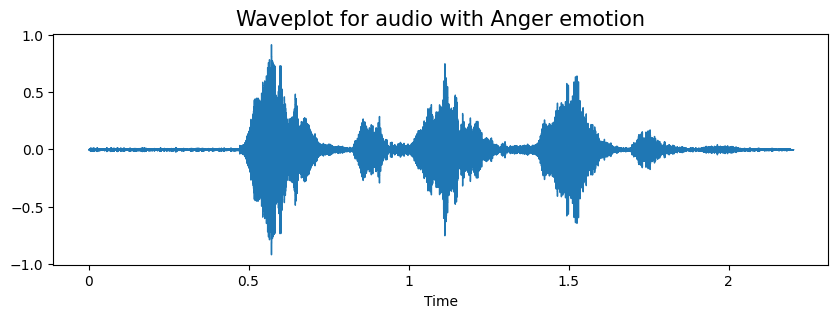

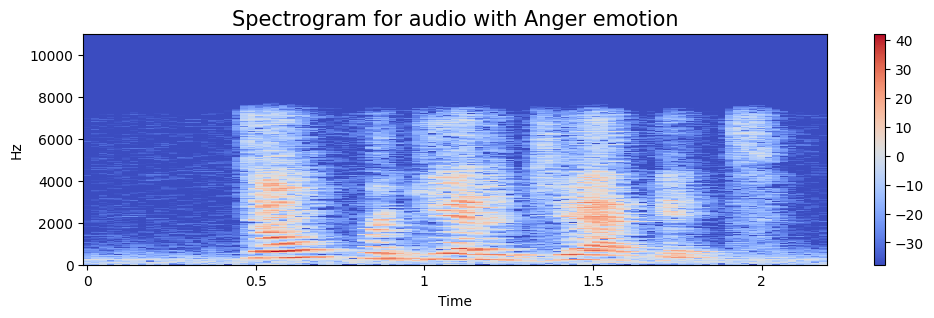

In [42]:
emotion='Anger'
angry_audio = get_audio('Anger')
data, sampling_rate = librosa.load(angry_audio[0])
create_waveplot(data, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(angry_audio[0])

### Fear

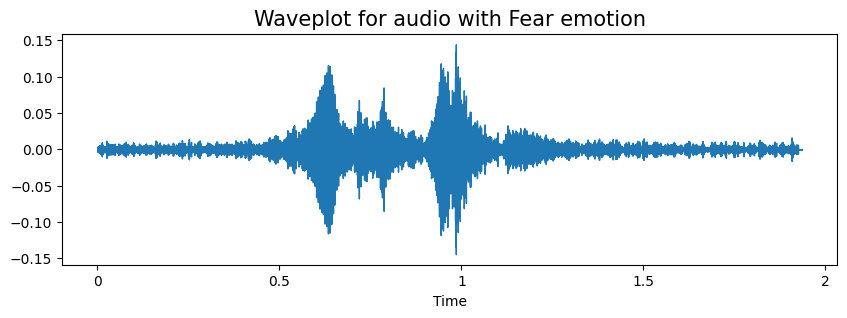

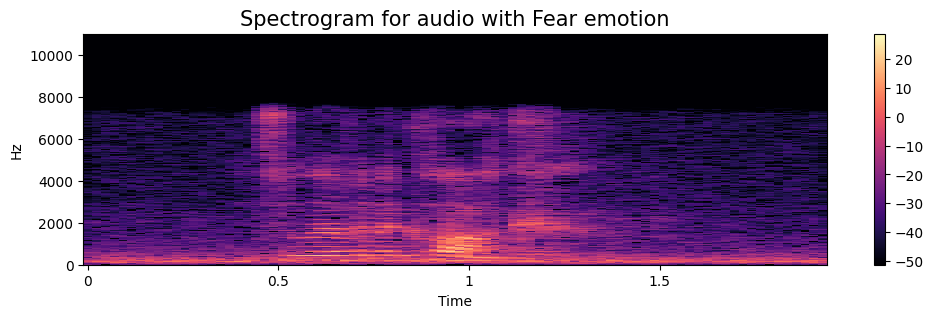

In [43]:
emotion='Fear'
fear_audio = get_audio('Fear')
data, sampling_rate = librosa.load(fear_audio[0])
create_waveplot(data, emotion)
create_spectrogram(data, sampling_rate,emotion)
Audio(fear_audio[0])

### Surprise

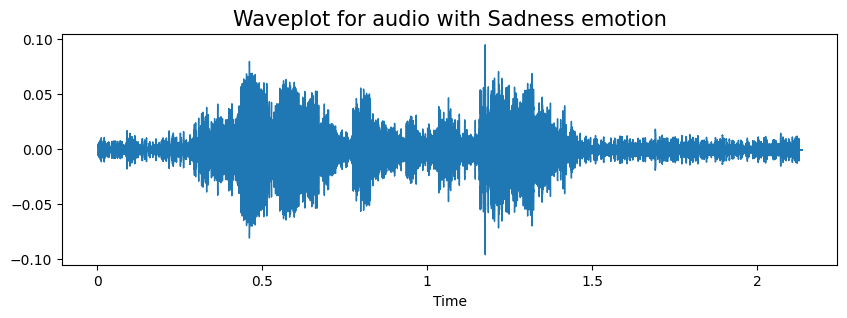

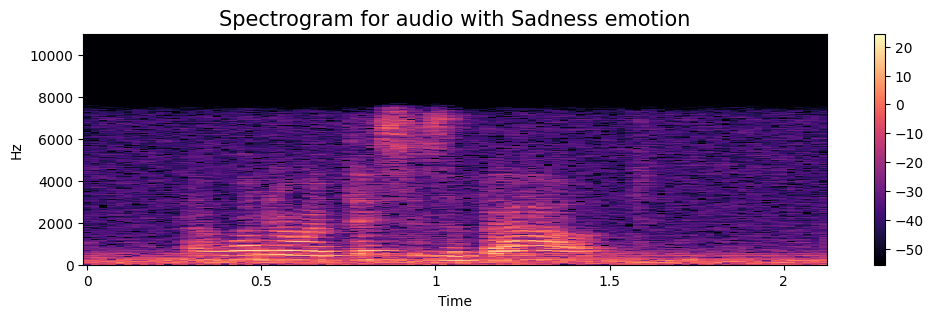

In [44]:
emotion = 'Sadness'
surprise_audio = get_audio('Sadness')
data, sampling_rate = librosa.load(surprise_audio[0])
create_waveplot(data, emotion)
create_spectrogram(data, sampling_rate,emotion)
Audio(surprise_audio[0])

### Happiness

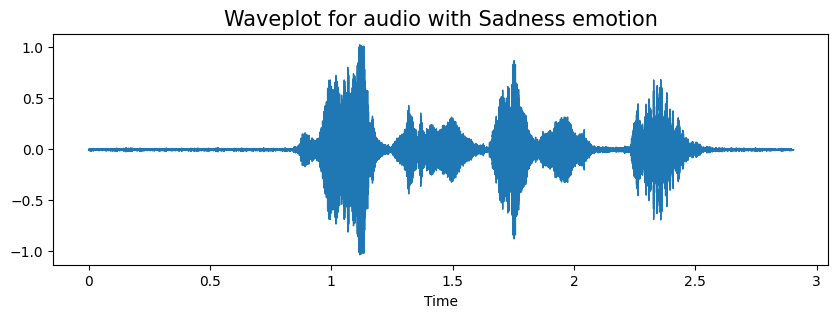

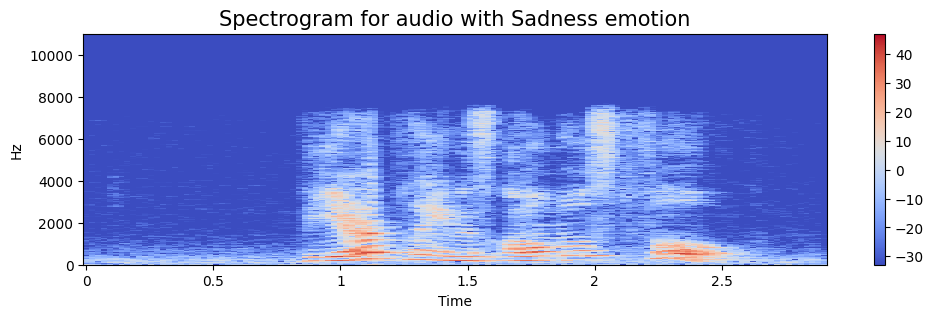

In [45]:
emothion = 'Happiness'
happy_audio = get_audio('Happiness')
data, sampling_rate = librosa.load(happy_audio[0])
create_waveplot(data, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(happy_audio[0])


### Neutral

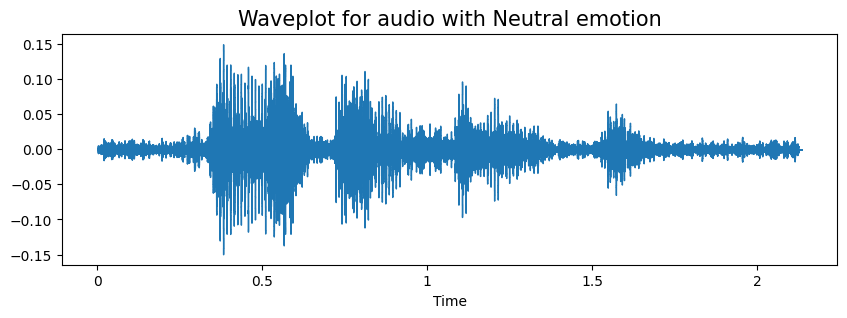

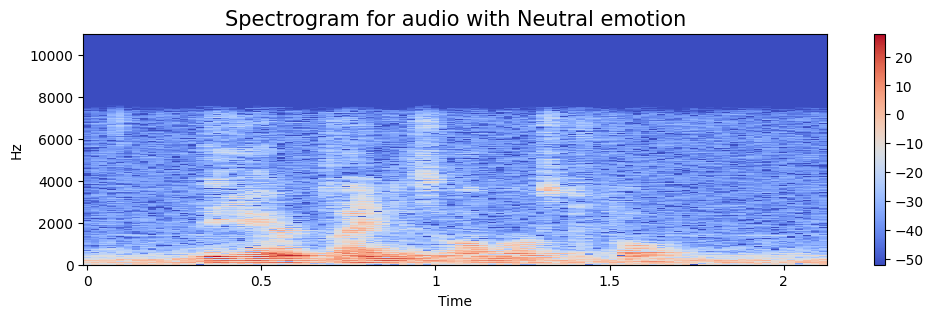

In [46]:
emotion = 'Neutral'
neutral_audio = get_audio('Neutral')
data, sampling_rate = librosa.load(neutral_audio[0])
create_waveplot(data, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(neutral_audio[0])

### Disgust

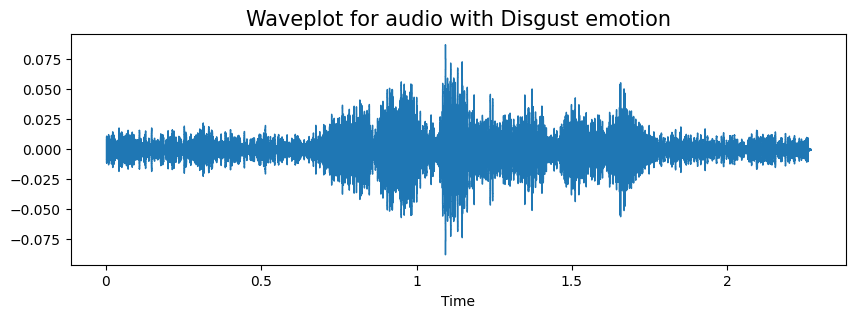

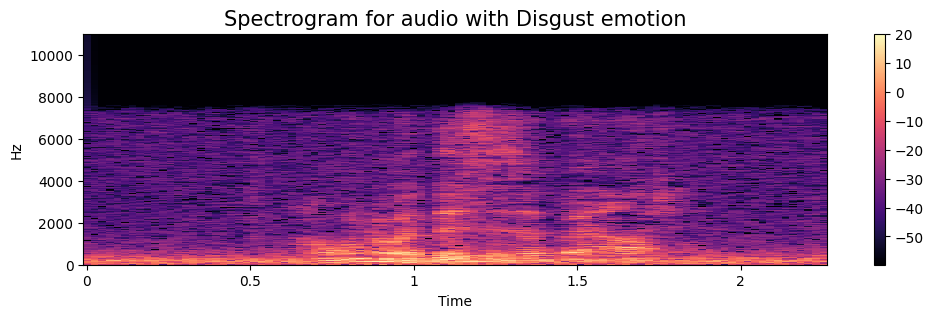

In [47]:
emotion = 'Disgust'
disgust_audio = get_audio('Disgust')
data, sampling_rate = librosa.load(disgust_audio[0])
create_waveplot(data, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(disgust_audio[0])

## Data augmentation


In [48]:
# define function to create data augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


# Feature extraction

**Audio signal is a 3D signal represented by time, amplitude and frequency**      


5 features : 
- Zero Crossing Rate
- Chroma_stft
- MFCC 
- RMS(root mean square) value
- MelSpectogram to train our model

In [49]:
# function to extract features
def extract_features(data):
    result = np.array([])
    # Zero crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(data).T, axis=0)
    rresult = np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # Mel-frequency cepstral coefficients
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally
    
    # Root mean square value
    rmsv = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rmsv))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(data, sr=sampling_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result

In [50]:
# Get features for each audio file without augmentation
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(data)
    result = np.array(res)
    return result

In [51]:
# Get features for each audio file with augmentation
def get_features_augmentation(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    res1 = extract_features(data)
    result = np.array(res1)

    # noise
    data_noise = noise(data)
    res2 = extract_features(data_noise)
    result = np.vstack((result, res2))

    # stretch
    data_stretch = stretch(data)
    res3 = extract_features(data_stretch)
    result = np.vstack((result, res3))
    
    return result

## GET FEATURES

### Get features with augmentation

In [52]:
# X, Y = [], []
# for path, emotion in zip(df_audio.Path, df_audio.Emotion):
#     feature = get_features_augmentation(path)  
#     for ele in feature:
#         X.append(ele)
#         Y.append(emotion)

In [53]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features_augmentation.csv', index=False)
# Features

### Get features without augmentation

In [54]:
# X, Y = [], []
# for path, emotion in zip(df_audio.Path, df_audio.Emotion):
#     feature = get_features(path)  
#     for ele in feature:
#         X.append(ele)
#         Y.append(emotion)

In [55]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features.csv', index=False)
# Features

### Features are stored in a csv to save time running time

In [56]:
features = pd.read_csv('features.csv')

In [57]:
features_aug = pd.read_csv('features_augmentation.csv')

In [58]:
features

,0,labels
0,0.593194,Fear
1,0.672318,Fear
2,0.598992,Fear
3,0.668625,Fear
4,0.724673,Fear
...,...,...
1346997,0.000008,Anger
1346998,0.000008,Anger
1346999,0.000008,Anger
1347000,0.000008,Anger


In [59]:
features_aug

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,labels
0,0.593194,0.672318,0.598992,0.668625,0.724673,0.646236,0.617308,0.632661,0.650408,0.769709,...,6.063221e-07,5.681581e-07,5.384327e-07,5.142654e-07,4.947777e-07,4.796652e-07,4.679835e-07,4.599293e-07,4.548293e-07,Fear
1,0.726671,0.714247,0.746628,0.856248,0.801862,0.676069,0.678004,0.686116,0.756005,0.820005,...,1.471283e-03,1.634039e-03,1.597378e-03,1.685120e-03,1.486540e-03,1.500595e-03,1.587548e-03,1.536391e-03,1.571894e-03,Fear
2,0.629704,0.653375,0.567347,0.682902,0.715813,0.624487,0.616261,0.632188,0.667359,0.782587,...,4.574725e-07,4.269455e-07,4.032305e-07,3.840327e-07,3.686063e-07,3.566627e-07,3.474569e-07,3.411100e-07,3.371066e-07,Fear
3,0.459892,0.527395,0.598135,0.610486,0.544318,0.554733,0.582980,0.616586,0.581965,0.604676,...,1.177034e-09,1.110903e-09,1.058523e-09,1.015227e-09,9.798233e-10,9.521613e-10,9.306194e-10,9.157149e-10,9.062003e-10,Happiness
4,0.533655,0.602613,0.669208,0.690929,0.618385,0.590096,0.593778,0.629592,0.605954,0.621903,...,1.302268e-03,1.249583e-03,1.263757e-03,1.180423e-03,1.301992e-03,1.368908e-03,1.234750e-03,1.224409e-03,1.291228e-03,Happiness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22321,0.733386,0.749478,0.718127,0.782358,0.814608,0.751670,0.747937,0.799806,0.900591,0.883424,...,4.218678e-04,4.421034e-04,4.229234e-04,4.108098e-04,4.071412e-04,4.185223e-04,4.252989e-04,4.195196e-04,4.021579e-04,Disgust
22322,0.561704,0.580529,0.540550,0.621320,0.642866,0.629252,0.669132,0.727816,0.881389,0.871827,...,2.492534e-08,2.338425e-08,2.225121e-08,2.129289e-08,2.051757e-08,1.994590e-08,1.950537e-08,1.915726e-08,1.895135e-08,Disgust
22323,0.599132,0.583664,0.587083,0.631302,0.687740,0.519200,0.471865,0.504317,0.586031,0.598225,...,1.000118e-05,9.397882e-06,8.926696e-06,8.542432e-06,8.231459e-06,7.990029e-06,7.802877e-06,7.673843e-06,7.592058e-06,Anger
22324,0.622688,0.610140,0.614655,0.661425,0.708419,0.523139,0.476110,0.508002,0.585994,0.599262,...,6.489087e-05,6.718968e-05,6.627259e-05,6.767537e-05,6.244651e-05,6.370328e-05,6.456354e-05,6.601519e-05,6.397609e-05,Anger


## Data Preparation no augmentation

In [60]:
X = features.iloc[:,:-1].values
Y = features['labels'].values

In [61]:
# Multiclass classification problem
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1)).toarray()

In [62]:
# splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, shuffle=True , test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1077601, 1), (1077601, 6), (269401, 1), (269401, 6))

In [63]:
# scaling our data with sklearn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape,Y_train.shape, X_test.shape, Y_test.shape

((1077601, 1), (1077601, 6), (269401, 1), (269401, 6))

In [64]:
# making our data compatible to model
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1077601, 1, 1), (1077601, 6), (269401, 1, 1), (269401, 6))

## Data Preparation augmentation

In [65]:
X_aug = features_aug.iloc[:,:-1].values
Y_aug = features_aug['labels'].values

In [66]:
# Multiclass classification problem
encoder = OneHotEncoder()
Y_aug = encoder.fit_transform(Y_aug.reshape(-1,1)).toarray()

In [67]:
# splitting data
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(X_aug, Y_aug, random_state=42, shuffle=True)
X_train_aug.shape, Y_train_aug.shape, X_test_aug.shape, Y_test_aug.shape

((16744, 181), (16744, 6), (5582, 181), (5582, 6))

In [68]:
# scaling our data with sklearn
scaler = StandardScaler()
X_train_aug = scaler.fit_transform(X_train_aug)
X_test_aug = scaler.transform(X_test_aug)
X_train_aug.shape,Y_train_aug.shape, X_test_aug.shape, Y_test_aug.shape

((16744, 181), (16744, 6), (5582, 181), (5582, 6))

In [79]:
# making our data compatible to model
X_train_aug = np.expand_dims(X_train_aug, axis=2)
X_test_aug = np.expand_dims(X_test_aug, axis=2)
X_train_aug.shape, Y_train_aug.shape, X_test_aug.shape, Y_test_aug.shape

((16744, 181, 1), (16744, 6), (5582, 181, 1), (5582, 6))

## Model building

### Callbacks and logs

In [69]:
# dictionary to keep history output from fit calls
logs = {}

# directory in which model checkpoints and logs are saved
LOG_DIR = 'logs'

def best_model_path(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    return os.path.join(base_dir, 'best_val_accuracy.ckpt')

def callback_list(model_name):
    base_dir  = os.path.join(LOG_DIR, model_name)
    tb_cb = tf.keras.callbacks.TensorBoard(base_dir)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
         best_model_path(model_name),
         monitor='val_accuracy',
         mode='max', 
         verbose=0,
         save_best_only=True)
    backup_dir = os.path.join(base_dir, 'backup_checkpoint')
    bkp = tf.keras.callbacks.BackupAndRestore(
        backup_dir)
    return [tb_cb, ckpt, bkp]

### Tensorboard

In [70]:
%load_ext tensorboard

In [71]:
%tensorboard --logdir logs

## BASE MODEL

In [72]:
# building our model
model = Sequential([
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Flatten(),
 layers.Dense(units=32, activation='relu'),

 layers.Dense(units=6, activation='softmax')
])

2022-12-17 13:54:54.032869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-17 13:54:54.032893: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-17 13:54:54.032908: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jlee-Aspire-A514-54): /proc/driver/nvidia/version does not exist
2022-12-17 13:54:54.034471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 256)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 256)            327936    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 256)           0

In [75]:
MODEL_NAME = 'Base'
logs[MODEL_NAME] = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_test, Y_test),
    batch_size=64, 
    epochs=10, 
    callbacks=callback_list(MODEL_NAME)
    )

Epoch 1/10
16838/16838 [==============================] - ETA: 0s - loss: 1.7780 - accuracy: 0.2060

INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 162s 10ms/step - loss: 1.7780 - accuracy: 0.2060 - val_loss: 1.7734 - val_accuracy: 0.2132
Epoch 2/10
16836/16838 [============================>.] - ETA: 0s - loss: 1.7734 - accuracy: 0.2131

INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 169s 10ms/step - loss: 1.7734 - accuracy: 0.2131 - val_loss: 1.7703 - val_accuracy: 0.2167
Epoch 3/10
16838/16838 [==============================] - 161s 10ms/step - loss: 1.7695 - accuracy: 0.2174 - val_loss: 1.7741 - val_accuracy: 0.2102
Epoch 4/10
16838/16838 [==============================] - 165s 10ms/step - loss: 1.7682 - accuracy: 0.2189 - val_loss: 1.7702 - val_accuracy: 0.2153
Epoch 5/10
16838/16838 [==============================] - 178s 11ms/step - loss: 1.7684 - accuracy: 0.2179 - val_loss: 1.7875 - val_accuracy: 0.1722
Epoch 6/10
16837/16838 [============================>.] - ETA: 0s - loss: 1.7669 - accuracy: 0.2198

INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 187s 11ms/step - loss: 1.7669 - accuracy: 0.2198 - val_loss: 1.7693 - val_accuracy: 0.2180
Epoch 7/10
16834/16838 [============================>.] - ETA: 0s - loss: 1.7659 - accuracy: 0.2210

INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 184s 11ms/step - loss: 1.7659 - accuracy: 0.2210 - val_loss: 1.7648 - val_accuracy: 0.2217
Epoch 8/10
16836/16838 [============================>.] - ETA: 0s - loss: 1.7652 - accuracy: 0.2219

INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Base/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 185s 11ms/step - loss: 1.7652 - accuracy: 0.2219 - val_loss: 1.7643 - val_accuracy: 0.2222
Epoch 9/10
16838/16838 [==============================] - 190s 11ms/step - loss: 1.7665 - accuracy: 0.2205 - val_loss: 1.7645 - val_accuracy: 0.2205
Epoch 10/10
16838/16838 [==============================] - 190s 11ms/step - loss: 1.7655 - accuracy: 0.2218 - val_loss: 1.7639 - val_accuracy: 0.2216


### Base model result

In [76]:
# Predict on test data
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test)

8419/8419 [==============================] - 20s 2ms/step


In [77]:
df_pred_base = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred_base.head(20)

,Actual,Predicted
0,Disgust,Sadness
1,Anger,Anger
2,Anger,Sadness
3,Disgust,Anger
4,Disgust,Anger
5,Anger,Sadness
6,Anger,Happiness
7,Neutral,Happiness
8,Sadness,Sadness
9,Fear,Sadness


## AUGMENTATION

In [78]:
# building our model
model = Sequential([
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_aug.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_aug.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Flatten(),
 layers.Dense(units=32, activation='relu'),

 layers.Dense(units=6, activation='softmax')

])

In [79]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 181, 256)          1536      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 91, 256)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 91, 256)           327936    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 46, 256)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 46, 256)           327936    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 23, 256)         

In [81]:
MODEL_NAME = 'Augmentation'
logs[MODEL_NAME] = model.fit(
    X_train_aug, 
    Y_train_aug, 
    validation_data=(X_test_aug, Y_test_aug),
    batch_size=64, 
    epochs=10, 
    callbacks=callback_list(MODEL_NAME)
    )

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 1.5660 - accuracy: 0.3334

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 33s 125ms/step - loss: 1.5660 - accuracy: 0.3334 - val_loss: 1.4817 - val_accuracy: 0.3879
Epoch 2/10
262/262 [==============================] - ETA: 0s - loss: 1.4495 - accuracy: 0.3958

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 122ms/step - loss: 1.4495 - accuracy: 0.3958 - val_loss: 1.4298 - val_accuracy: 0.4142
Epoch 3/10
262/262 [==============================] - ETA: 0s - loss: 1.3983 - accuracy: 0.4260

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 121ms/step - loss: 1.3983 - accuracy: 0.4260 - val_loss: 1.3859 - val_accuracy: 0.4398
Epoch 4/10
262/262 [==============================] - ETA: 0s - loss: 1.3620 - accuracy: 0.4410

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 123ms/step - loss: 1.3620 - accuracy: 0.4410 - val_loss: 1.3547 - val_accuracy: 0.4570
Epoch 5/10
262/262 [==============================] - ETA: 0s - loss: 1.3233 - accuracy: 0.4615

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 122ms/step - loss: 1.3233 - accuracy: 0.4615 - val_loss: 1.3286 - val_accuracy: 0.4676
Epoch 6/10
262/262 [==============================] - ETA: 0s - loss: 1.2932 - accuracy: 0.4735

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 122ms/step - loss: 1.2932 - accuracy: 0.4735 - val_loss: 1.3135 - val_accuracy: 0.4738
Epoch 7/10
262/262 [==============================] - ETA: 0s - loss: 1.2588 - accuracy: 0.4932

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 122ms/step - loss: 1.2588 - accuracy: 0.4932 - val_loss: 1.3037 - val_accuracy: 0.4744
Epoch 8/10
262/262 [==============================] - ETA: 0s - loss: 1.2284 - accuracy: 0.5073

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 121ms/step - loss: 1.2284 - accuracy: 0.5073 - val_loss: 1.2613 - val_accuracy: 0.5050
Epoch 9/10
262/262 [==============================] - 31s 118ms/step - loss: 1.1890 - accuracy: 0.5219 - val_loss: 1.2567 - val_accuracy: 0.5032
Epoch 10/10
262/262 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.5327

INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 123ms/step - loss: 1.1598 - accuracy: 0.5327 - val_loss: 1.2407 - val_accuracy: 0.5072


### Augmentation model results

In [82]:
# Predict on test data
pred_test = model.predict(X_test_aug)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test_aug)

175/175 [==============================] - 3s 17ms/step


In [83]:
df_pred_aug = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred_aug.head(20)

,Actual,Predicted
0,Sadness,Sadness
1,Neutral,Disgust
2,Fear,Anger
3,Fear,Anger
4,Fear,Neutral
5,Disgust,Disgust
6,Happiness,Happiness
7,Sadness,Sadness
8,Sadness,Sadness
9,Disgust,Disgust


**Compurtation time is much more faster with augmented data**

## DROPOUT MODEL

In [114]:
# def create_model(dropout_rate):
#  model = Sequential([
#  layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
#  layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#  layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
#  layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

#  layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
#  layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

#  layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
#  layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
#  layers.Dropout(dropout_rate),

#  layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
#  layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

#  layers.Flatten(),
#  layers.Dense(units=32, activation='relu'),
#  layers.Dropout(dropout_rate+0.1),

#  layers.Dense(units=6, activation='softmax')

#  ])

#  # Compile model
#  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#  return model

In [117]:
# # use grid search to find the best dropout rate
# param_grid = dict(dropout_rate=[0.2, 0.3, 0.4, 0.5])
# model = KerasClassifier(build_fn=create_model, epochs=1, batch_size=64, verbose=1)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train, Y_train)
# # print the best dropout rate
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2022-12-17 15:58:31.770484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 15:58:31.830827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 15:58:31.832534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

 1090/13471 [=>............................] - ETA: 12:35 - loss: 1.7861 - accuracy: 0.1889

KeyboardInterrupt: 

In [118]:
# building our model
model = Sequential([
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
 layers.Dropout(0.2),

 layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Flatten(),
 layers.Dense(units=32, activation='relu'),
 layers.Dropout(0.3),

 layers.Dense(units=6, activation='softmax')
])

In [119]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [120]:
MODEL_NAME = 'Dropout'
logs[MODEL_NAME] = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_test, Y_test),
    batch_size=64, 
    epochs=10, 
    callbacks=callback_list(MODEL_NAME)
    )

Epoch 1/10
16837/16838 [============================>.] - ETA: 0s - loss: 1.7787 - accuracy: 0.2059

INFO:tensorflow:Assets written to: logs/Dropout/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 201s 12ms/step - loss: 1.7787 - accuracy: 0.2059 - val_loss: 1.7752 - val_accuracy: 0.2114
Epoch 2/10
16836/16838 [============================>.] - ETA: 0s - loss: 1.7759 - accuracy: 0.2121

INFO:tensorflow:Assets written to: logs/Dropout/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout/best_val_accuracy.ckpt/assets


16838/16838 [==============================] - 175s 10ms/step - loss: 1.7759 - accuracy: 0.2121 - val_loss: 1.7776 - val_accuracy: 0.2216
Epoch 3/10
16838/16838 [==============================] - 172s 10ms/step - loss: 1.7745 - accuracy: 0.2137 - val_loss: 1.7684 - val_accuracy: 0.2207
Epoch 4/10
16838/16838 [==============================] - 170s 10ms/step - loss: 1.7734 - accuracy: 0.2155 - val_loss: 1.7716 - val_accuracy: 0.2161
Epoch 5/10
16838/16838 [==============================] - 164s 10ms/step - loss: 1.7733 - accuracy: 0.2158 - val_loss: 1.7742 - val_accuracy: 0.2139
Epoch 6/10
16838/16838 [==============================] - 165s 10ms/step - loss: 1.7730 - accuracy: 0.2165 - val_loss: 1.7763 - val_accuracy: 0.2102
Epoch 7/10
16838/16838 [==============================] - 165s 10ms/step - loss: 1.7716 - accuracy: 0.2180 - val_loss: 1.7688 - val_accuracy: 0.2194
Epoch 8/10
16838/16838 [==============================] - 168s 10ms/step - loss: 1.7718 - accuracy: 0.2170 - val_loss

### Dropout model results

In [121]:
# Predict on test data
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test)

8419/8419 [==============================] - 22s 3ms/step


In [122]:
df_pred_dropout = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred_dropout.head(20)

,Actual,Predicted
0,Disgust,Sadness
1,Anger,Anger
2,Anger,Sadness
3,Disgust,Anger
4,Disgust,Anger
5,Anger,Sadness
6,Anger,Happiness
7,Neutral,Happiness
8,Sadness,Sadness
9,Fear,Sadness


## AUGMENTATION AND DROPOUT MODEL


In [123]:
# building our model
model = Sequential([
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_aug.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train_aug.shape[1], 1)),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
 layers.Dropout(0.2),

 layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
 layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

 layers.Flatten(),
 layers.Dense(units=32, activation='relu'),
 layers.Dropout(0.3),

 layers.Dense(units=6, activation='softmax')
])

In [124]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [125]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f697e664310>>

In [126]:
MODEL_NAME = 'Dropout and Augmentation'
logs[MODEL_NAME] = model.fit(
    X_train_aug, 
    Y_train_aug, 
    validation_data=(X_test_aug, Y_test_aug),
    batch_size=64, 
    epochs=10, 
    callbacks=callback_list(MODEL_NAME)
    )

Epoch 1/10
262/262 [==============================] - ETA: 0s - loss: 1.5869 - accuracy: 0.3184

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 35s 131ms/step - loss: 1.5869 - accuracy: 0.3184 - val_loss: 1.5056 - val_accuracy: 0.3619
Epoch 2/10
262/262 [==============================] - ETA: 0s - loss: 1.5190 - accuracy: 0.3551

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 119ms/step - loss: 1.5190 - accuracy: 0.3551 - val_loss: 1.4771 - val_accuracy: 0.3821
Epoch 3/10
262/262 [==============================] - ETA: 0s - loss: 1.4854 - accuracy: 0.3773

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 32s 120ms/step - loss: 1.4854 - accuracy: 0.3773 - val_loss: 1.4608 - val_accuracy: 0.4074
Epoch 4/10
262/262 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.3938

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 120ms/step - loss: 1.4595 - accuracy: 0.3938 - val_loss: 1.4376 - val_accuracy: 0.4167
Epoch 5/10
262/262 [==============================] - ETA: 0s - loss: 1.4302 - accuracy: 0.4089

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 118ms/step - loss: 1.4302 - accuracy: 0.4089 - val_loss: 1.3945 - val_accuracy: 0.4359
Epoch 6/10
262/262 [==============================] - ETA: 0s - loss: 1.4047 - accuracy: 0.4232

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 119ms/step - loss: 1.4047 - accuracy: 0.4232 - val_loss: 1.3849 - val_accuracy: 0.4425
Epoch 7/10
262/262 [==============================] - ETA: 0s - loss: 1.3771 - accuracy: 0.4392

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 119ms/step - loss: 1.3771 - accuracy: 0.4392 - val_loss: 1.3593 - val_accuracy: 0.4434
Epoch 8/10
262/262 [==============================] - ETA: 0s - loss: 1.3578 - accuracy: 0.4436

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 118ms/step - loss: 1.3578 - accuracy: 0.4436 - val_loss: 1.3723 - val_accuracy: 0.4511
Epoch 9/10
262/262 [==============================] - ETA: 0s - loss: 1.3392 - accuracy: 0.4584

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 120ms/step - loss: 1.3392 - accuracy: 0.4584 - val_loss: 1.3439 - val_accuracy: 0.4554
Epoch 10/10
262/262 [==============================] - ETA: 0s - loss: 1.3090 - accuracy: 0.4670

INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


INFO:tensorflow:Assets written to: logs/Dropout and Augmentation/best_val_accuracy.ckpt/assets


262/262 [==============================] - 31s 118ms/step - loss: 1.3090 - accuracy: 0.4670 - val_loss: 1.2977 - val_accuracy: 0.4790


### Dropout and augmentation model results

In [127]:
# Predict on test data
pred_test = model.predict(X_test_aug)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(Y_test_aug)

175/175 [==============================] - 4s 23ms/step


In [128]:
df_pred_aug_drop= pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_pred_aug_drop.head(20)

,Actual,Predicted
0,Sadness,Sadness
1,Neutral,Disgust
2,Fear,Happiness
3,Fear,Anger
4,Fear,Neutral
5,Disgust,Neutral
6,Happiness,Happiness
7,Sadness,Sadness
8,Sadness,Sadness
9,Disgust,Neutral


# COMPARE THE RESULTS